<a href="https://colab.research.google.com/github/AyushiKashyapp/KnowledgeGraphs/blob/main/AutomaticKG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Knowledge Graph Creation

Automating and scaling the process of creating knowledge graph using NLP.

Building a Knowledge Grpah from a list of factual statements sampled from the GenericKB dataset by extracting information such as entities (people, places, things or generally nouns) and the relationship between the entities from text based resources (e.g a wikipedia page).

In [ ]:
!wget https://raw.githubusercontent.com/dhairyadalal/kg-lab6/master/generics_filtered.csv

--2024-06-12 18:27:03--  https://raw.githubusercontent.com/dhairyadalal/kg-lab6/master/generics_filtered.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21232393 (20M) [text/plain]
Saving to: ‘generics_filtered.csv’

generics_filtered.c 100%[===================>]  20.25M  88.3MB/s    in 0.2s    

2024-06-12 18:27:04 (88.3 MB/s) - ‘generics_filtered.csv’ saved [21232393/21232393]



In [ ]:
!pip install -U spacy

In [ ]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 12.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!pip install jupyter ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 9.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
generics = pd.read_csv("generics_filtered.csv")
data = generics.sample(1000, random_state=1988)["GENERIC SENTENCE"].tolist()

**Knowledge Extraction from Text**

NLP can be used to automate knowledge extraction. We can break down the process into relevant tasks: entity extraction, relation extraction, and entity linking.

**Named Entity Extraction**

Named entity usually refers to specific people, places, and things. These are useful to extract when constructing knowledge graphs.

In [ ]:
import spacy

nlp = spacy.load("en_core_web_md")

def extract_entities(text):

  doc = nlp(text)
  extracted_entities = [ent.text for ent in doc.ents]
  return extracted_entities

In [ ]:
for sent in data[:10]:
  print(f"Sentence: {sent}")
  print(f"Extracted entities: {extract_entities(sent)}")

Sentence: A belly is a body part
Extracted entities: []
Sentence: Duchesses have (part) vacuoles.
Extracted entities: ['Duchesses']
Sentence: Essential oil offers certain benefits.
Extracted entities: []
Sentence: Ozone is a strong oxidizer that helps control algae and bacteria.
Extracted entities: []
Sentence: Nurses are located in nursing homes.
Extracted entities: []
Sentence: Phagocytes have (part) lobes.
Extracted entities: ['Phagocytes']
Sentence: Cattle are located in villages.
Extracted entities: []
Sentence: Calculations reveal answers.
Extracted entities: []
Sentence: A token is a symbol
Extracted entities: []
Sentence: Cuts are strokes.
Extracted entities: []


**Entity and Relation extraction using Dependency Parsing**

Knowledge can be extrated from text using syntax and grammer.

Dependency parsing is used to identify dependency relationships between phrases based on grammatical structure. Dependency parses can be expressed as tree containing root element and left and right children that are related by the root.

In [ ]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_md")
doc = nlp("Nurses are located in nursing homes.")
displacy.render(doc, style="dep", jupyter=True)

list(doc[3].children)

[homes]

Spacy can be used to parse a sentence and get back list of dependency parse values and trees, part of speech tags and the lemmatized forms of the words.

In [ ]:
for tok in doc:
  print(tok, tok.dep_, tok.pos_, tok.lemma_)

  if tok.dep_ == "ROOT":
    print("------------------")
    print("Root token is: ", tok)
    print("Left children: ", list(tok.lefts))
    for lt in tok.lefts:
      print(f"\t{lt.lemma_}, {lt.dep_}, {lt.pos_}")
    print("Right children: ", list(tok.rights))
    for rt in tok.rights:
      print(f"\t{rt.lemma_}, {rt.dep_}, {rt.pos_}")
    print("------------------")

Nurses nsubjpass NOUN nurse
are auxpass AUX be
located ROOT VERB locate
------------------
Root token is:  located
Left children:  [Nurses, are]
	nurse, nsubjpass, NOUN
	be, auxpass, AUX
Right children:  [in, .]
	in, prep, ADP
	., punct, PUNCT
------------------
in prep ADP in
nursing compound NOUN nursing
homes pobj NOUN home
. punct PUNCT .


**Triple Extraction using Dependency Parsing**

In [ ]:
def extract_triple(sentence):

   head, relation, tail = None, None, None
   doc = nlp(sentence)

   def find(ts):
    ts = list(ts)
    heads = [l.lemma_ for l in ts if l.pos_ == "NOUN"]
    if len(heads) > 0:
      return heads[0]
    else:
      heads = [find(l.children) for l in ts]
      heads = [h for h in heads if h is not None]
      if len(heads) > 0:
        return heads[0]
      else:
        return None

   for tok in doc:
    if tok.dep_ == "ROOT":
      return {"head": find(tok.lefts), "relation": tok.lemma_, "tail": find(tok.rights)}

   return {"head": head, "relation": relation, "tail": tail}

print(extract_triple("Elephants are large mammals and can be found in the Serengeti."))

{'head': 'elephant', 'relation': 'be', 'tail': 'mammal'}


In [ ]:
for sent in data[:5]:
  print(sent)
  print(extract_triple(sent))
  print("----------------")

A belly is a body part
{'head': 'belly', 'relation': 'be', 'tail': 'part'}
----------------
Duchesses have (part) vacuoles.
{'head': 'duchess', 'relation': 'have', 'tail': 'vacuole'}
----------------
Essential oil offers certain benefits.
{'head': 'oil', 'relation': 'offer', 'tail': 'benefit'}
----------------
Ozone is a strong oxidizer that helps control algae and bacteria.
{'head': 'ozone', 'relation': 'be', 'tail': 'oxidizer'}
----------------
Nurses are located in nursing homes.
{'head': 'nurse', 'relation': 'locate', 'tail': 'home'}
----------------


**Triple Extraction using Semantic Roles**

An alternative to dependency parsing is semantic role labeling (SRL). It aims to parse texts using the word and phrases's semantic role in the sentence (agent, goal or result).

**Entity Linking**

Entity linking is the process of mapping entities extracted from text to known entities in a knowledge base. It can be used to augment knowledge bases with new facts against known entities.


In [ ]:
import urllib.parse, urllib.request, json

def CallWikifier(text, lang="en", threshold=0.8):
    # Prepare the URL.
    data = urllib.parse.urlencode([
        ("text", text), ("lang", lang),
        ("userKey", "krgqcsqqjhpgypwnbkdwusbtuuuxwl"),
        ("pageRankSqThreshold", "%g" % threshold), ("applyPageRankSqThreshold", "true"),
        ("nTopDfValuesToIgnore", "200"), ("nWordsToIgnoreFromList", "200"),
        ("wikiDataClasses", "true"), ("wikiDataClassIds", "false"),
        ("support", "true"), ("ranges", "false"), ("minLinkFrequency", "2"),
        ("includeCosines", "false"), ("maxMentionEntropy", "5")
        ])
    url = "http://www.wikifier.org/annotate-article"
    # Call the Wikifier and read the response.
    req = urllib.request.Request(url, data=data.encode("utf8"), method="POST")
    with urllib.request.urlopen(req, timeout = 60) as f:
        response = f.read()
        response = json.loads(response.decode("utf8"))
    # Output the annotations.
    return response["annotations"]


CallWikifier("Swift is an American singer.")

[{'title': 'Swift (bird)',
  'url': 'http://en.wikipedia.org/wiki/Swift_(bird)',
  'lang': 'en',
  'pageRank': 0.04675895822945004,
  'secLang': 'en',
  'secTitle': 'Swift (bird)',
  'secUrl': 'http://en.wikipedia.org/wiki/Swift_(bird)',
  'dbPediaTypes': [],
  'dbPediaIri': '',
  'supportLen': 1,
  'support': [{'wFrom': 0,
    'wTo': 0,
    'chFrom': 0,
    'chTo': 4,
    'pMentionGivenSurface': 0.05950872603915478,
    'pageRank': 0.05898081724892712,
    'prbConfidence': 0.1100408940201721,
    'entropy': 3.791144886199782}]}]

In [ ]:
def CallWikifier2(text):
  annotations = CallWikifier(text)

  return [{
      "text": text[a["support"][0]["chFrom"]:a["support"][0]["chTo"]+1],
      "title": a["title"],
      "url": a["url"]
  } for a in annotations]

CallWikifier2("Elephants are large mammals and can be found in the Serengeti")

[{'text': 'mammals',
  'title': 'Mammal',
  'url': 'http://en.wikipedia.org/wiki/Mammal'},
 {'text': 'Serengeti',
  'title': 'Serengeti',
  'url': 'http://en.wikipedia.org/wiki/Serengeti'}]

**Building a knowledge graph**

In [ ]:
import tqdm.notebook as tqdm

extracted_knowledge = []

for sentence in tqdm.tqdm(data):
  extracted_knowledge.append(extract_triple(sentence))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
import networkx as nx
G = nx.Graph()

from collections import Counter

node_freq = Counter()

for triple in extracted_knowledge:
  if triple["head"] is not None and triple["tail"] is not None:
    G.add_edge(triple["head"], triple["tail"], label=triple["relation"])
    node_freq[triple["head"]] += 1
    node_freq[triple["tail"]] += 1

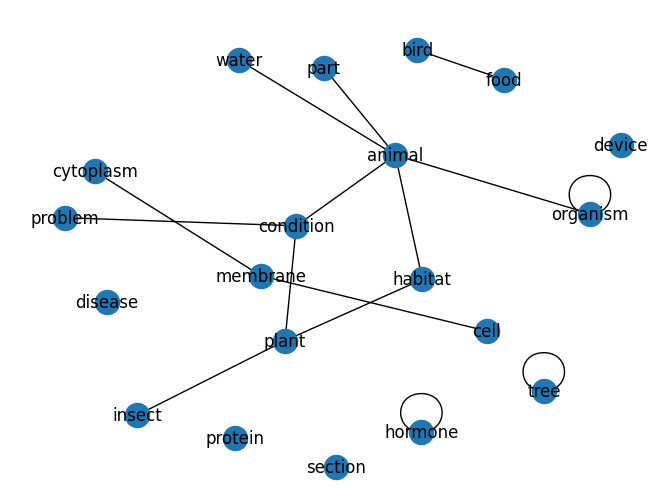

In [ ]:
import matplotlib.pyplot as plt

G2 = G.subgraph(x[0] for x in node_freq.most_common(20))

pos = nx.spring_layout(G2, k=1)
nx.draw(G2, pos, with_labels=True)

plt.show()